In [17]:
import sys
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import keras

from tqdm import tqdm
from matplotlib import pyplot as plt

from src.visualization import set_themes
from src.preprocessing import construct_features_meta
from src.preprocessing.data_loader import load_data
from src.sampler import SimpleSampler
from src.losses.bayesian_personalized_ranking import BayesianPersonalizedRankingLoss
from src.models.matrix_factorization import MatrixFactorization

from collections import defaultdict

set_themes()
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

# Load Datasets

In [2]:
train_user_interaction = load_data("dataset/yelp2018/train.txt")
train_features_meta = construct_features_meta(train_user_interaction)
train_user_interaction

,user_id,item_id
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4
...,...,...
1237254,31667,22984
1237255,31667,12943
1237256,31667,29149
1237257,31667,4927


In [3]:
test_user_interaction = load_data("dataset/yelp2018/test.txt")
test_user_interaction

,user_id,item_id
0,0,795
1,0,694
2,0,1531
3,0,14517
4,0,8784
...,...,...
324142,31667,33811
324143,31667,10482
324144,31667,9585
324145,31667,36460


In [4]:
user_items = train_user_interaction.groupby("user_id")["item_id"].apply(set).to_dict()
item_users = train_user_interaction.groupby("item_id")["user_id"].apply(set).to_dict()

In [5]:
{feature_name: {k: v for k, v in meta.items() if k not in ["vocabulary"]} for feature_name, meta in train_features_meta.items()}

{'user_id': {'dtype': 'int64', 'unique_count': 31668},
 'item_id': {'dtype': 'int64', 'unique_count': 38048}}

# Model Definition

In [6]:
sampler = SimpleSampler(item_set=train_features_meta["item_id"]["vocabulary"], user_items=user_items)

model = MatrixFactorization(
    train_features_meta, 
    embedding_dimension_count=8,
    l2_regularization=1e-6
)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss_functions=[
        BayesianPersonalizedRankingLoss()
    ],
    sampler=sampler
)

# Model Training

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    {
        "user_id": train_user_interaction["user_id"].values,
        "item_id": train_user_interaction["item_id"].values
    }
)
test_dataset = tf.data.Dataset.from_tensor_slices(
    {
        "user_id": test_user_interaction["user_id"].values,
        "item_id": test_user_interaction["item_id"].values
    }
)
print(f"Training Dataset: {len(train_dataset)}")
print(f"Test Dataset: {len(test_dataset)}")

Training Dataset: 1237259
Test Dataset: 324147


In [8]:
model.fit(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    nepochs=10,
    shuffle=True,
    batch_size=16384
)

[1/10]: 100%|█████████████████████████████| 1237259/1237259 [00:06<00:00, 197080.65it/s, loss=0.683]
2026-01-10 13:02:55.717581: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
[2/10]: 100%|█████████████████████████████| 1237259/1237259 [00:04<00:00, 304651.25it/s, loss=0.438]
2026-01-10 13:03:00.181702: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
[4/10]: 100%|█████████████████████████████| 1237259/1237259 [00:04<00:00, 296949.66it/s, loss=0.158]
2026-01-10 13:03:09.227414: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
[8/10]: 100%|█████████████████████████████| 1237259/1237259 [00:04<00:00, 308325.45it/s, loss=0.114]
2026-01-10 13:03:26.792508: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: 

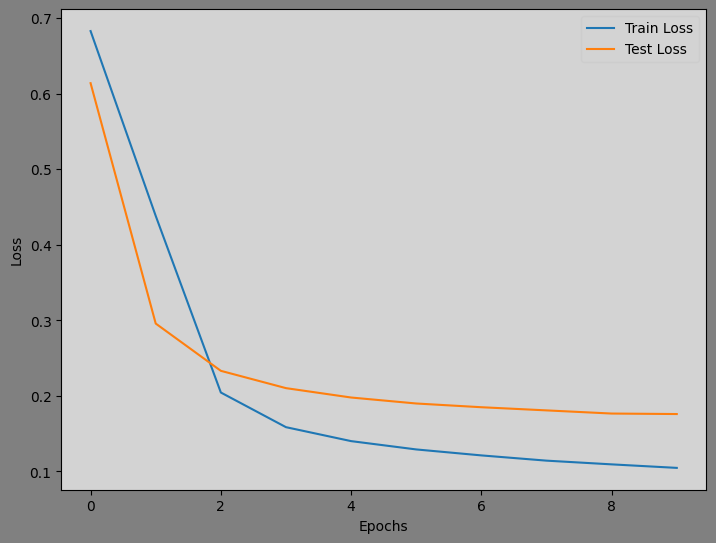

failed to send, dropping 1 traces to intake at http://localhost:8126/v0.5/traces after 3 retries, 8 additional messages skipped


In [ ]:
plt.plot(model.train_loss_history, label="Train Loss")
plt.plot(model.test_loss_history, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Archive

In [10]:
nepochs = 1
loss_batch_history = []
loss_epoch_history = []
for epoch in range(nepochs):
    current_batch_losses = []
    with tqdm(total=len(train_user_interaction), ncols=100, desc=f"[{epoch+1}/{nepochs}]") as pbar:
        for step, training_batch in enumerate(train_dataset.batch(16384)):
            user_ids = training_batch["user_id"]
            item_ids = training_batch["item_id"]

            # random negative sample
            random_negatives = model.sampler.sample(user_ids)
            
            with tf.GradientTape() as tape:
                user_embedding = model.user_embedding(user_ids)
                item_embedding = model.item_embedding(item_ids)
                negative_embedding = model.item_embedding(random_negatives)

                positive_prediction = tf.reduce_sum(user_embedding * item_embedding, axis=-1)
                negative_prediction = tf.reduce_sum(user_embedding * negative_embedding, axis=-1)

                loss_value = tf.reduce_mean(-tf.math.log(tf.sigmoid(positive_prediction - negative_prediction)))

            # calculate gradient
            user_gradient, item_gradient = tape.gradient(loss_value, model.user_embedding_layer.trainable_variables + model.item_embedding_layer.trainable_variables)

            # back propagation
            model.optimizer.apply_gradients(zip([user_gradient, item_gradient], model.user_embedding_layer.trainable_variables + model.item_embedding_layer.trainable_variables))

            loss_batch_history.append(float(loss_value))
            current_batch_losses.append(float(loss_value))

            pbar.update(len(user_ids))
            pbar.set_postfix({"loss": float(loss_value)})
    loss_epoch_history.append(float(tf.reduce_mean(current_batch_losses)))

[1/1]:   1%|▍                                 | 16384/1237259 [00:00<00:04, 257478.54it/s, loss=0.1]

[1/1]: 100%|█████████████████████████████| 1237259/1237259 [00:02<00:00, 563208.02it/s, loss=0.0982]


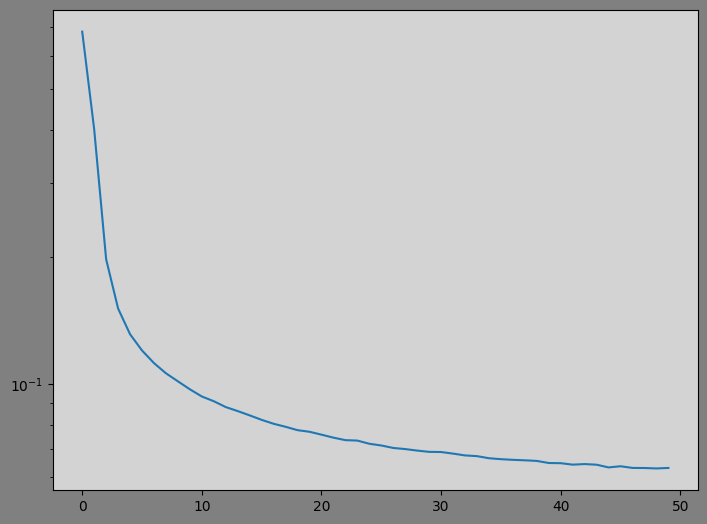

In [11]:
plt.plot(loss_epoch_history)
plt.yscale("log")
plt.show()

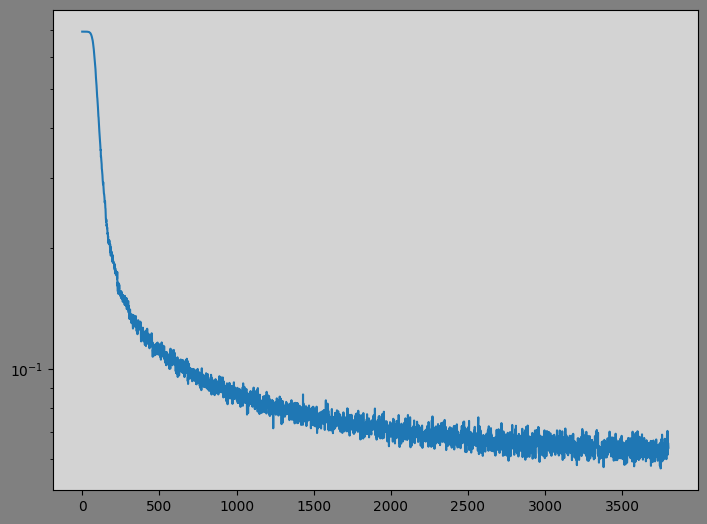

In [12]:
plt.plot(loss_batch_history)
plt.yscale("log")
plt.show()